# Movie Rating Prediction Notebook

In [47]:
# Import required libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as pxnbformat
import plotly.graph_objects as go
import plotly.io as pio
import nbformat
from plotly.subplots import make_subplots
from IPython.display import display, HTML, Image
from importlib import reload
from matplotlib_venn import venn2

# Configure plotting settings
plt.style.use('default')  # Using default matplotlib style
sns.set_theme()  # Set seaborn theme properly
plt.rcParams['figure.figsize'] = [12, 6]
pio.renderers.default = "notebook"

# Add the backend directory to Python path
current_dir = os.path.dirname(os.path.abspath(''))
backend_dir = os.path.join(current_dir, 'backend')
if backend_dir not in sys.path:
    sys.path.append(backend_dir)

# Import and reload predictor module to get latest changes
try:
    import predictor
    reload(predictor)
    from predictor import MovieRatingPredictor
except ImportError as e:
    print(f"Import Error: {e}")
    print(f"Searching in paths: {sys.path}")
    sys.exit(1)

# Initialize predictor
predictor = MovieRatingPredictor()

## Dataset Analysis

First, let's analyze our datasets using the `describe()` method from our predictor class.

In [4]:
# Get dataset description
description = predictor.describe()

if description:
    print("=== Dataset Statistics ===")
    print("-" * 50)
    for dataset_name, stats in description['dataset_statistics'].items():
        print(f"\n{stats['name']}:")
        print(f"Number of rows: {stats['rows']:,}")
        print(f"Number of columns: {stats['columns']}")
        print(f"Size in MB: {stats['size_mb']:.2f}")
        
    print("\n=== Data Sources ===")
    print("-" * 50)
    for source_name, info in description['data_sources'].items():
        print(f"\n{info['source']}:")
        print(f"Description: {info['description']}")
        print(f"URL: {info['url']}")
else:
    print("Error: Could not retrieve dataset description")

=== Dataset Statistics ===
--------------------------------------------------

IMDb Movies:
Number of rows: 5,043
Number of columns: 28
Size in MB: 1.42

TMDB Movies:
Number of rows: 45,466
Number of columns: 24
Size in MB: 32.85

=== Data Sources ===
--------------------------------------------------

IMDb Movies Dataset:
Description: Contains detailed movie information including ratings and metadata
URL: https://www.kaggle.com/code/aditimulye/imdb-5000-movie-dataset-analysis

TMDB 45K Movies Dataset:
Description: Contains comprehensive movie information including budget, revenue, and detailed metadata
URL: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/data?select=movies_metadata.csv


In [5]:
# Debug: Print the structure of the description dictionary in a readable format
if description:
    print("=== Description Dictionary Structure ===")
    print("\nAvailable keys:", ", ".join(description.keys()))
    
    def print_nested_dict(d, indent=0):
        for key, value in d.items():
            if isinstance(value, dict):
                print("\n" + " " * indent + f"{key}:")
                print_nested_dict(value, indent + 4)
            else:
                if isinstance(value, list):
                    print(" " * indent + f"{key}: [")
                    for item in value:
                        print(" " * (indent + 4) + f"- {item}")
                    print(" " * indent + "]")
                else:
                    wrapped_value = str(value)
                    if len(wrapped_value) > 80:
                        wrapped_value = wrapped_value[:77] + "..."
                    print(" " * indent + f"{key}: {wrapped_value}")
    
    for key in description:
        print(f"\n{'='*20} {key} {'='*20}")
        print_nested_dict(description[key])
        print()
else:
    print("No description data available")

=== Description Dictionary Structure ===

Available keys: dataset_statistics, data_sources, erd

==================== dataset_statistics ====================

imdb:
    name: IMDb Movies
    rows: 5043
    columns: 28
    size_mb: 1.4206352233886719

    null_counts:
        color: 19
        director_name: 104
        num_critic_for_reviews: 50
        duration: 15
        director_facebook_likes: 104
        actor_3_facebook_likes: 23
        actor_2_name: 13
        actor_1_facebook_likes: 7
        gross: 884
        genres: 0
        actor_1_name: 7
        movie_title: 0
        num_voted_users: 0
        cast_total_facebook_likes: 0
        actor_3_name: 23
        facenumber_in_poster: 13
        plot_keywords: 153
        movie_imdb_link: 0
        num_user_for_reviews: 21
        language: 12
        country: 5
        content_rating: 303
        budget: 492
        title_year: 108
        actor_2_facebook_likes: 13
        imdb_score: 0
        aspect_ratio: 329
        movi

### Null Value Analysis

Let's visualize the null values in both datasets to better understand our data quality.

In [6]:
# Configure plotly for notebook display
import plotly.io as pio
from IPython.display import display, HTML

# Create null value visualization for both datasets
def plot_null_values(dataset_info, title):
    if 'null_counts' not in dataset_info:
        print(f"No null value information found for {title}")
        return
        
    null_data = pd.Series(dataset_info['null_counts'])
    total_rows = dataset_info['rows']
    
    # Calculate percentage of null values
    null_data_pct = (null_data / total_rows * 100).round(2)
    null_data_pct = null_data_pct[null_data_pct > 0].sort_values(ascending=True)
    
    if len(null_data_pct) > 0:
        # Create the bar plot using plotly.graph_objects for more control
        fig = go.Figure()
        
        # Add bars for null counts
        fig.add_trace(go.Bar(
            x=null_data_pct.values,
            y=null_data_pct.index,
            orientation='h',
            name='Null Percentage',
            text=[f"{v:.1f}% ({null_data[i]:,} rows)" for i, v in null_data_pct.items()],
            textposition='auto',
        ))
        
        fig.update_layout(
            title=f'Null Values in {title} (Total Rows: {total_rows:,})',
            xaxis_title='Percentage of Null Values',
            yaxis_title='Column Name',
            height=max(400, len(null_data_pct)*30),
            showlegend=False,
            xaxis=dict(range=[0, 100]),  # Set x-axis from 0 to 100%
            template='plotly_white'  # Use a clean template
        )
        
        # Convert to HTML and display
        html_str = fig.to_html(include_plotlyjs='cdn', full_html=False)
        display(HTML(html_str))
    else:
        print(f"No null values found in {title}")

print("=== Null Value Analysis ===")
print("This analysis shows the percentage of missing values in each column.\n")

# Plot null values for both datasets
if description and 'dataset_statistics' in description:
    for dataset_name, dataset_info in description['dataset_statistics'].items():
        print(f"\nAnalyzing null values in {dataset_info['name']}...")
        plot_null_values(dataset_info, dataset_info.get('name', dataset_name))
else:
    print("Error: Dataset statistics not found in description")

=== Null Value Analysis ===
This analysis shows the percentage of missing values in each column.


Analyzing null values in IMDb Movies...



Analyzing null values in TMDB Movies...


## Entity Relationship Diagram (ERD)

This will help us understand:
- The main entities in our system
- Their attributes and relationships
- The cardinality between different entities
- Primary and foreign key relationships

=== Entity Relationship Diagram ===

This diagram shows the relationships between different entities in our database:
- Boxes represent entities
- Bold attributes are Primary Keys (PK)
- Italic attributes are Foreign Keys (FK)
- Lines show relationships between entities
- Numbers (1,N) show cardinality of relationships



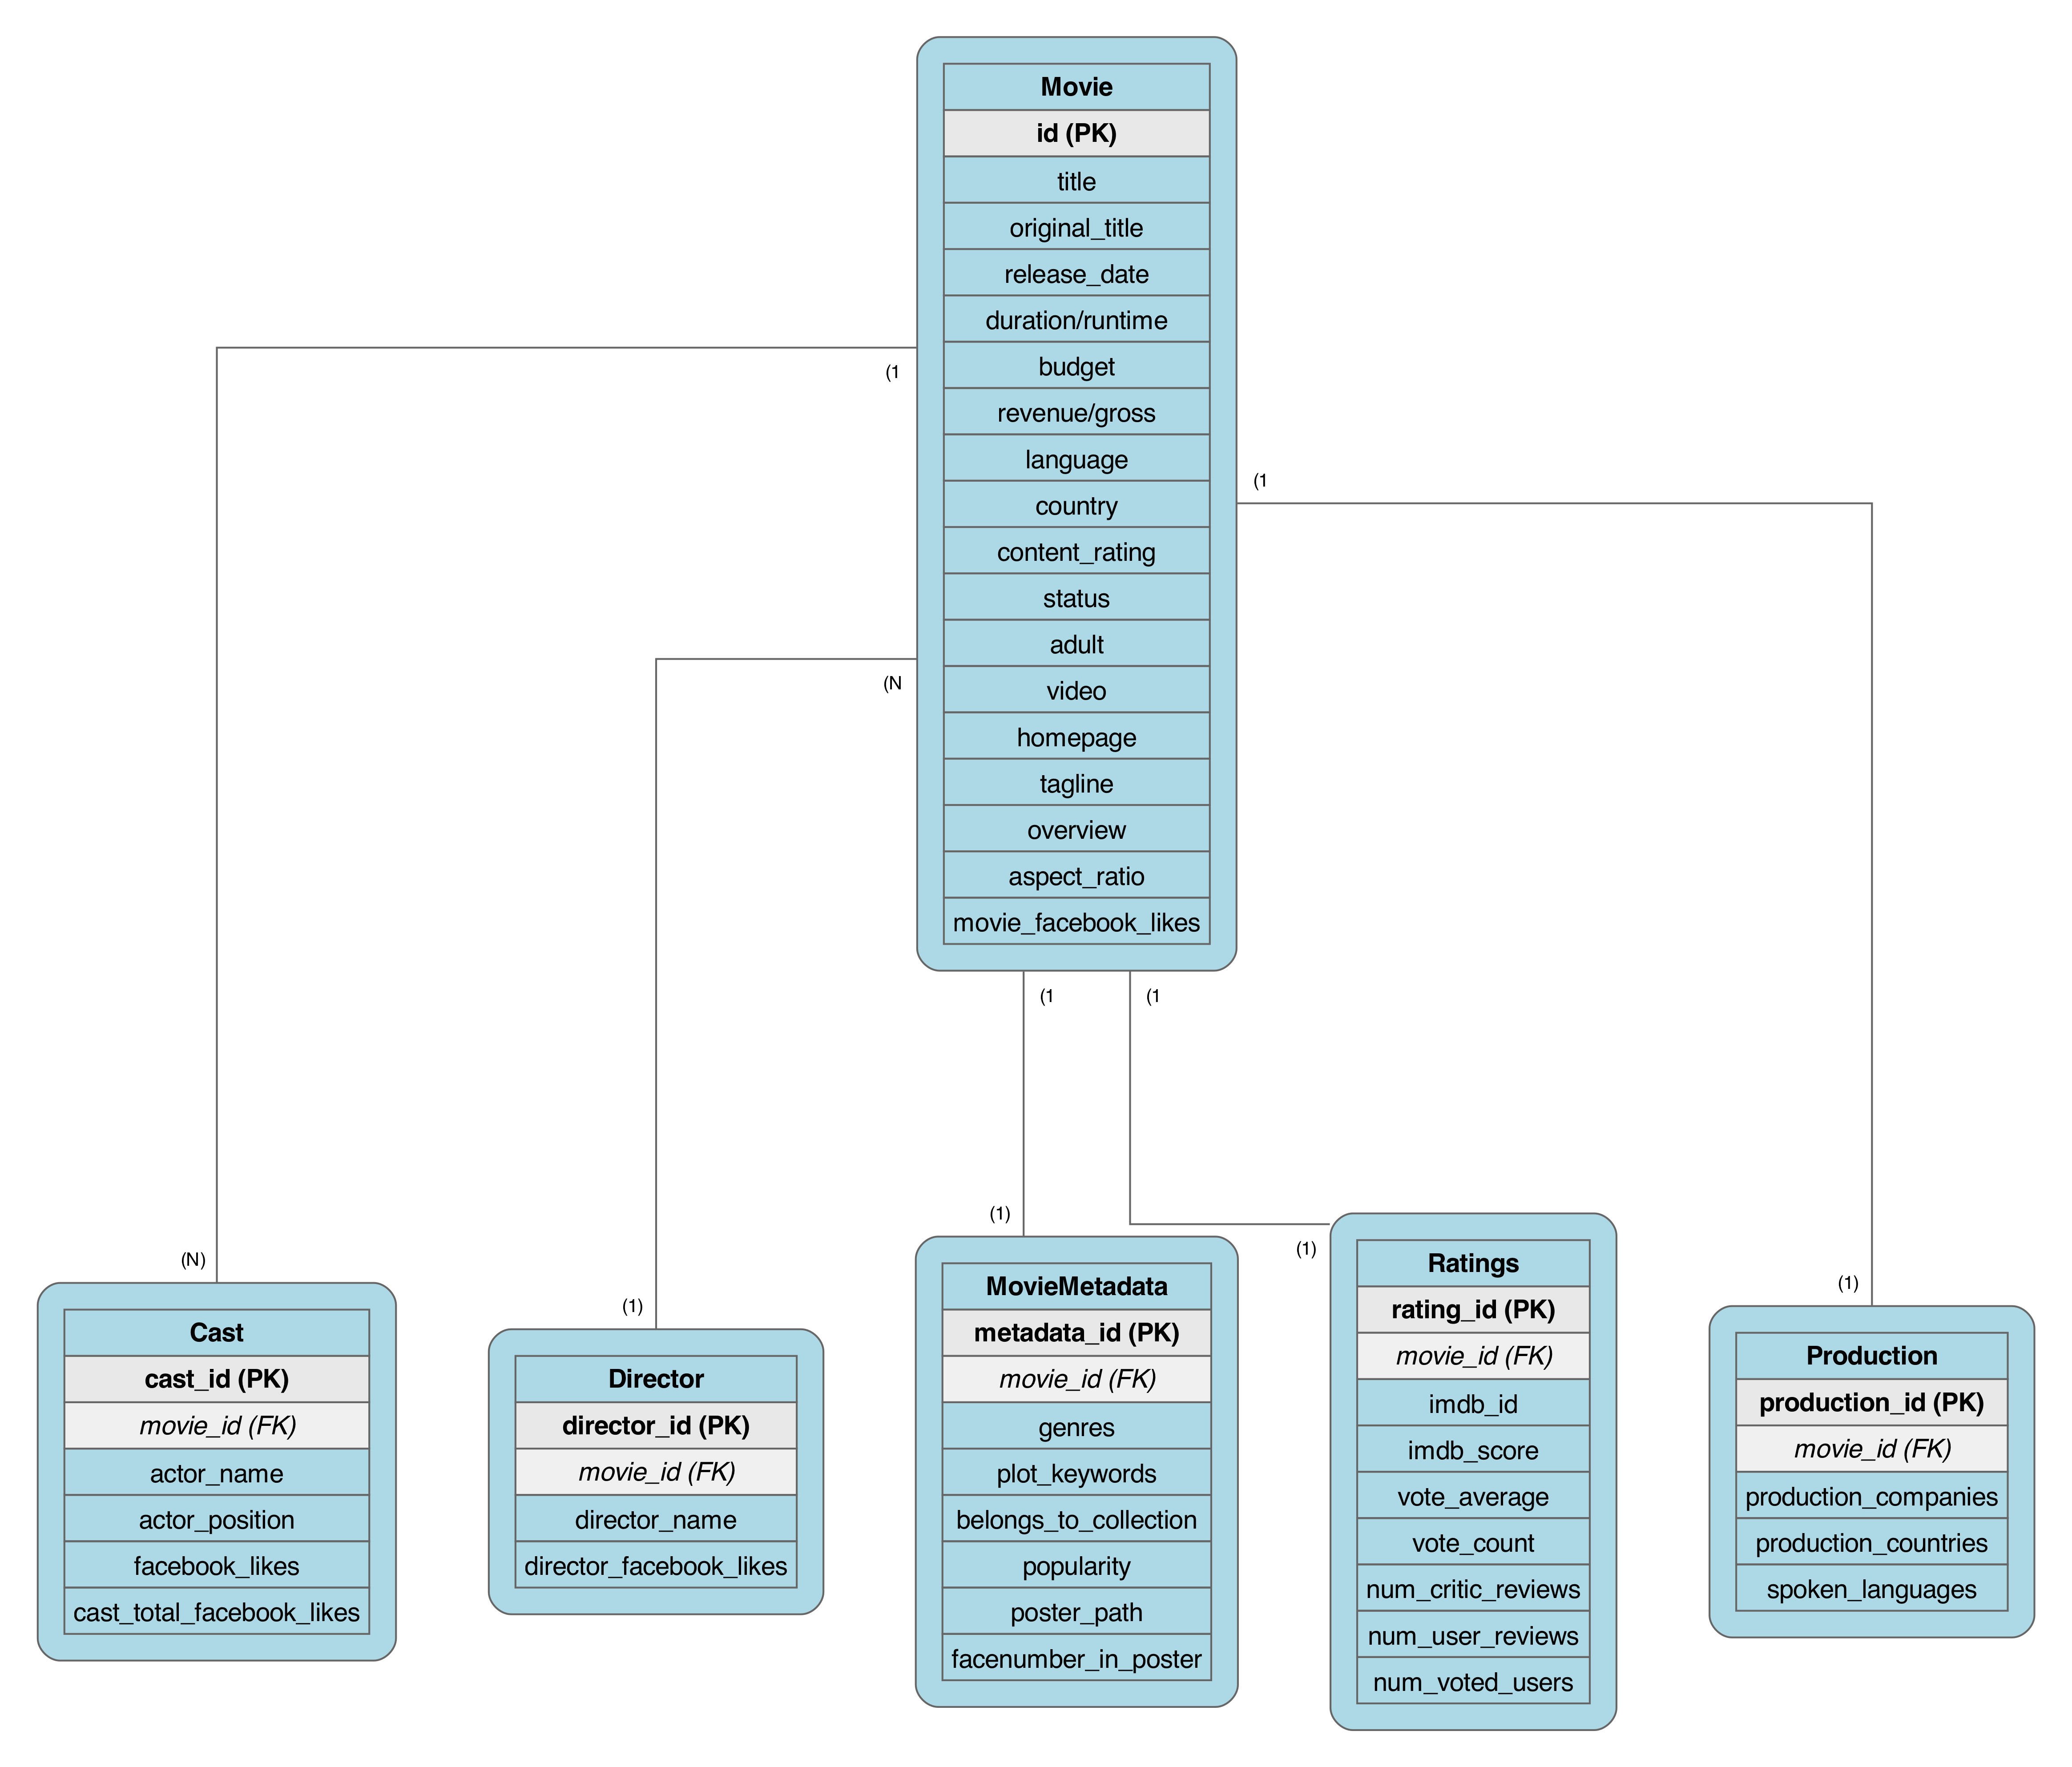

In [7]:
from graphviz import Digraph

def create_erd(erd_info):
    """Create ERD visualization using Graphviz"""
    if not erd_info:
        return "No ERD information available"
        
    # Create a new directed graph
    dot = Digraph(name='Movie Database ERD', 
                  comment='Entity Relationship Diagram for Movie Database',
                  format='png')
    
    # Graph attributes for better visualization
    dot.attr(rankdir='TB',     # Top to Bottom layout
            splines='ortho',   # Orthogonal lines
            nodesep='0.7',     # Increased spacing between nodes
            ranksep='0.9',     # Increased rank spacing
            ratio='fill')      # Fill the available space
    
    # Node attributes
    dot.attr('node', shape='box', 
            style='rounded,filled', 
            fillcolor='lightblue',
            fontname='Helvetica',
            margin='0.2',
            color='#666666')  # Lighter border color
    
    # Edge attributes
    dot.attr('edge', fontname='Helvetica',
            fontsize='10',
            color='#666666',   # Matching edge color
            minlen='2',        # Minimum edge length
            labelfloat='true', # Allow labels to float away from lines
            labeldistance='1.8',
            labelangle='45')   # Angle labels to prevent overlap

    # Create subgraph for center placement
    with dot.subgraph(name='cluster_0') as s0:
        s0.attr(rank='same', style='invis')
        # Add Movie entity in center
        entity_info = erd_info['entities']['Movie']
        label = create_entity_label('Movie', entity_info)
        s0.node('Movie', label=label)
        
    # Create subgraph for left side entities
    with dot.subgraph(name='cluster_1') as s1:
        s1.attr(rank='same', style='invis')
        # Add Cast and Director
        for entity_name in ['Cast', 'Director']:
            if entity_name in erd_info['entities']:
                label = create_entity_label(entity_name, erd_info['entities'][entity_name])
                s1.node(entity_name, label=label)

    # Create subgraph for right side entities
    with dot.subgraph(name='cluster_2') as s2:
        s2.attr(rank='same', style='invis')
        # Add MovieMetadata, Ratings, and Production
        for entity_name in ['MovieMetadata', 'Ratings', 'Production']:
            if entity_name in erd_info['entities']:
                label = create_entity_label(entity_name, erd_info['entities'][entity_name])
                s2.node(entity_name, label=label)
    
    # Add relationships with improved label placement
    for rel in erd_info['relationships']:
        entity1, cardinality = rel.split(' -- ')
        entity1 = entity1.strip('()')
        entity2 = cardinality.strip('()').split()[1]
        card_type = cardinality.split()[0]
        
        # Create edges with better label placement
        dot.edge(entity1.split()[0], entity2,
                headlabel=f' {card_type} ',     # Add spaces for better separation
                taillabel=f' {entity1.split()[1]} ',  # Add spaces for better separation
                dir='both',
                arrowhead='crow' if card_type == 'N' else 'none',
                arrowtail='none')
    
    return dot

def create_entity_label(entity_name, entity_info):
    """Helper function to create entity label with attributes"""
    label = f'<<TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0" CELLPADDING="4" COLOR="#666666">\n'
    label += f'<TR><TD PORT="header" BGCOLOR="#ADD8E6" BORDER="1"><B>{entity_name}</B></TD></TR>\n'
    for attr in entity_info['attributes']:
        if '(PK)' in attr:
            label += f'<TR><TD PORT="{attr}" BGCOLOR="#E8E8E8" BORDER="1"><B>{attr}</B></TD></TR>\n'
        elif '(FK)' in attr:
            label += f'<TR><TD PORT="{attr}" BGCOLOR="#F0F0F0" BORDER="1"><I>{attr}</I></TD></TR>\n'
        else:
            label += f'<TR><TD PORT="{attr}" BORDER="1">{attr}</TD></TR>\n'
    label += '</TABLE>>'
    return label

if description and 'erd' in description:
    print("=== Entity Relationship Diagram ===")
    print("\nThis diagram shows the relationships between different entities in our database:")
    print("- Boxes represent entities")
    print("- Bold attributes are Primary Keys (PK)")
    print("- Italic attributes are Foreign Keys (FK)")
    print("- Lines show relationships between entities")
    print("- Numbers (1,N) show cardinality of relationships\n")
    
    # Create and display ERD
    erd = create_erd(description['erd'])
    if isinstance(erd, str):
        print(erd)
    else:
        # Save in analysis directory
        analysis_dir = os.path.join(current_dir, 'analysis')
        os.makedirs(analysis_dir, exist_ok=True)
        erd_path = os.path.join(analysis_dir, 'movie_erd')

        # Render with higher DPI for better quality and landscape orientation
        erd.attr(dpi='300')
        erd.render(erd_path, format='png', cleanup=True)
        
        # Display the generated ERD
        display(Image(filename=f"{erd_path}.png"))
else:
    print("Error: ERD information not found in description")

# Testing the integrate() Method

Let's test the data integration process and analyze the merged dataset.

In [51]:
try:
    import predictor

    reload(predictor)
    from predictor import MovieRatingPredictor
except ImportError as e:
    print(f"Import Error: {e}")
    print(f"Searching in paths: {sys.path}")
    sys.exit(1)

# Initialize predictor
predictor = MovieRatingPredictor()
# Get the merged dataset
merged_df = predictor.integrate()

if merged_df is not None:

    print(len(merged_df))

    # Display basic information about the merged dataset
    print("=== Merged Dataset Overview ===")
    print(f"Total rows: {len(merged_df):,}")
    print(f"Total columns: {len(merged_df.columns):,}")
    print("\nMemory usage: {:.2f} MB".format(merged_df.memory_usage(deep=True).sum() / 1024**2))


    # Display first few rows with a subset of columns
    print("\n=== First Few Rows (Selected Columns) ===")
    selected_cols = merged_df.columns[:50]  # First 50 columns
    display(merged_df[selected_cols].head())

    # Display statistical summary
    print("\n=== Statistical Summary ===")
    display(merged_df.describe(include='all').T)

    # Show column data types
    print("\n=== Column Data Types ===")
    display(pd.DataFrame({
        'Data Type': merged_df.dtypes,
        'Non-Null Count': merged_df.count(),
        'Null %': (merged_df.isnull().sum() / len(merged_df) * 100).round(2)
    }))
else:
    print("Error: Failed to integrate datasets")

5281
=== Merged Dataset Overview ===
Total rows: 5,281
Total columns: 36

Memory usage: 6.88 MB

=== First Few Rows (Selected Columns) ===


,color,director,critic_votes,duration_x,director_likes,actor_3_likes,actor_2,actor_1_likes,gross_x,genres_x,...,genres_y,production_companies,production_countries,year_y,gross_y,duration_y,languages_y,rating_y,user_votes_y,content_rating_y
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,"[Action, Adventure, Fantasy, Sci-Fi]",...,"[Action, Adventure, Fantasy, Science Fiction]","[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2009.0,2.787965e+09,162.0,"[English, Español]",7.2,12114.0,nan
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,"[Action, Adventure, Fantasy]",...,"[Adventure, Fantasy, Action]","[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],2007.0,9.610000e+08,169.0,[English],6.9,4627.0,nan
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,"[Action, Adventure, Thriller]",...,"[Action, Adventure, Crime]","[Columbia Pictures, Danjaq, B24]","[United Kingdom, United States of America]",2015.0,8.806746e+08,148.0,"[Français, English, Español, Italiano, Deutsch]",6.3,4552.0,nan
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,"[Action, Thriller]",...,"[Action, Crime, Drama, Thriller]","[Legendary Pictures, Warner Bros., DC Entertai...",[United States of America],2012.0,1.084939e+09,165.0,[English],7.6,9263.0,nan
4,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,"[Action, Adventure, Sci-Fi]",...,"[Action, Adventure, Science Fiction]",[Walt Disney Pictures],[United States of America],2012.0,2.841391e+08,132.0,[English],6.1,2170.0,nan



=== Statistical Summary ===


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
color,5270,2,Color,5042,NaN,NaN,NaN,NaN,NaN,NaN,NaN
director,5179,2070,Kenneth Branagh,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
critic_votes,5269.0,NaN,NaN,NaN,152.573733,125.710257,1.0,60.0,121.0,212.0,813.0
duration_x,5276.0,NaN,NaN,NaN,108.743366,26.597675,7.0,94.0,104.0,118.0,511.0
director_likes,5179.0,NaN,NaN,NaN,749.341572,2929.914413,0.0,8.0,54.0,221.0,23000.0
actor_3_likes,5270.0,NaN,NaN,NaN,747.922391,1879.45604,0.0,168.0,403.0,660.0,23000.0
actor_2,5275,2643,Morgan Freeman,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
actor_1_likes,5278.0,NaN,NaN,NaN,7243.980296,14795.744871,0.0,690.0,1000.0,12000.0,640000.0
gross_x,4514.0,NaN,NaN,NaN,53569941.389677,73368098.119315,162.0,7556708.0,30061595.5,67604214.0,760505847.0
genres_x,5281,847,[Drama],226,NaN,NaN,NaN,NaN,NaN,NaN,NaN



=== Column Data Types ===


,Data Type,Non-Null Count,Null %
color,object,5270,0.21
director,object,5179,1.93
critic_votes,float64,5269,0.23
duration_x,float64,5276,0.09
director_likes,float64,5179,1.93
actor_3_likes,float64,5270,0.21
actor_2,object,5275,0.11
actor_1_likes,float64,5278,0.06
gross_x,float64,4514,14.52
genres_x,object,5281,0.00


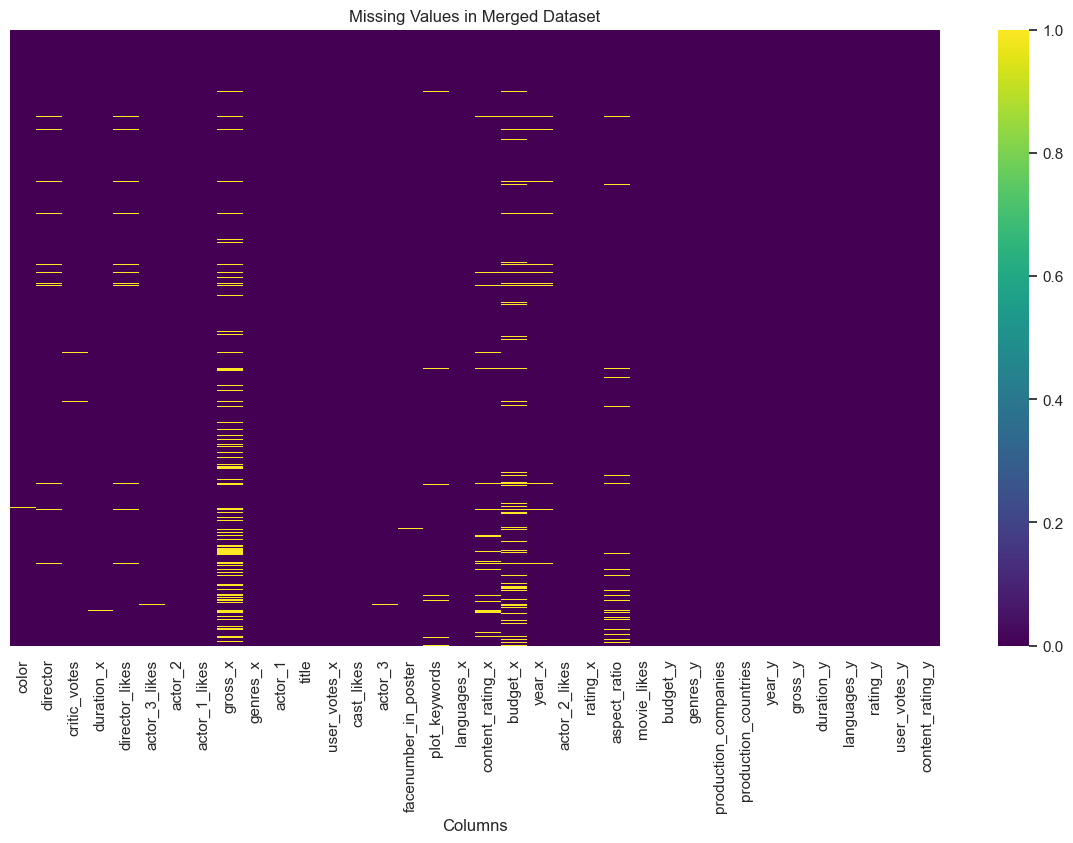

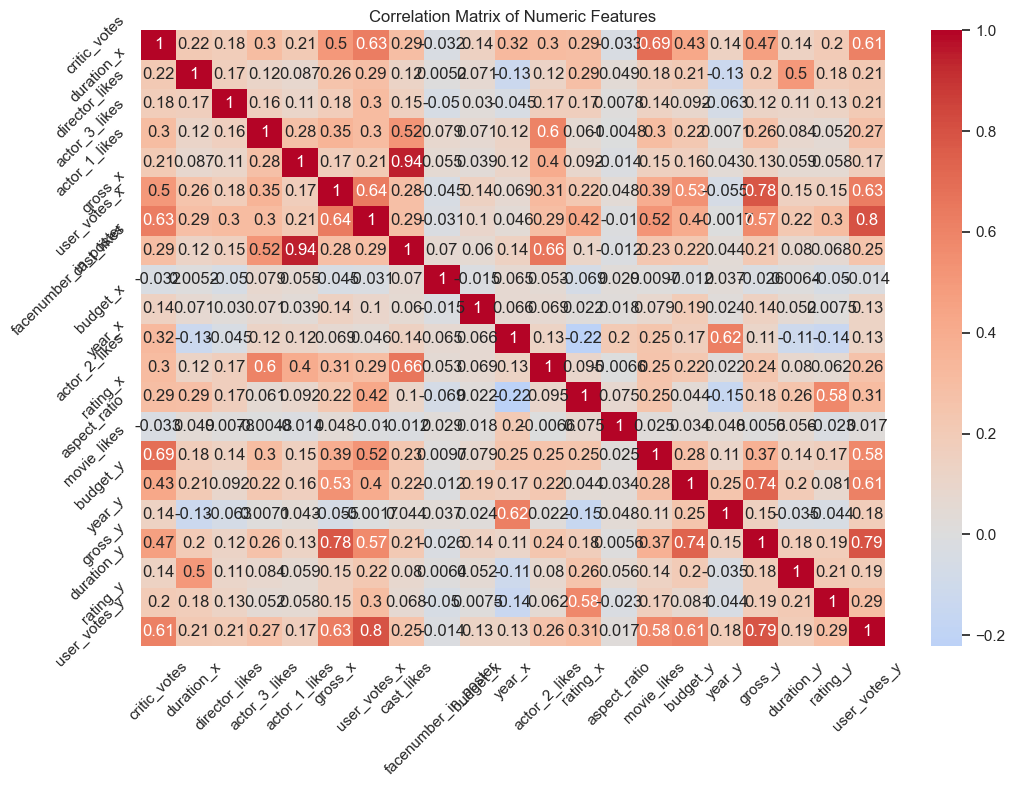

ValueError: Could not interpret value `rating` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

In [52]:
# Create visualizations for the merged dataset
if merged_df is not None:
    # 1. Missing values heatmap
    plt.figure(figsize=(15, 8))
    sns.heatmap(merged_df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
    plt.title('Missing Values in Merged Dataset')
    plt.xlabel('Columns')
    plt.show()
    
    # 2. Correlation matrix for numeric columns
    numeric_cols = merged_df.select_dtypes(include=['float64', 'int64']).columns
    if len(numeric_cols) > 0:
        plt.figure(figsize=(12, 8))
        correlation_matrix = merged_df[numeric_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Correlation Matrix of Numeric Features')
        plt.xticks(rotation=45)
        plt.yticks(rotation=45)
        plt.show()
    
    # 3. Distribution of ratings
    plt.figure(figsize=(10, 6))
    sns.histplot(data=merged_df, x='rating', bins=30, kde=True)
    plt.title('Distribution of Movie Ratings')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.show()
else:
    print("No visualizations created: Dataset integration failed")